# Машинное обучение
## Домашнее задание №1: KNN + Линейные модели

**Срок сдачи:** 10 октября 2023, 23:59

**Максимально баллов:** 10 

**Штраф за опоздание:** по 2 балла за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла. Формат сдачи будет указан чуть позже.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 баллов

При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность.

## KNN (5 баллов)

In [272]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [273]:
class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors, algorithm='brute', metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric


    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.x_train = np.array(X)
            self.y_train = np.array(y)
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X, leaf_size=5)
            self.y_train = y


    def predict(self, X):
        
        pred_arr = []

        if self.algorithm == 'brute':
            y_train = self.y_train.reshape(-1, 1)
            
            dist_x = np.array([distance.cdist(self.x_train, [x], self.metric).reshape(len(self.x_train)) for x in X])

            dist_x_with_index = [sorted([(dist[i], i) for i in range(len(dist_x[0]))])[:self.n_neighbors] for dist in dist_x]
            
            most_simillar = np.array([[self.y_train[item[j][1]] for j in range(len(item))] for item in dist_x_with_index])
            
            for item in most_simillar:
                unique, counts = np.unique(item, return_counts=True)
                max_ind = unique[np.argmax(counts)]
                pred_arr.append(max_ind)
        
        elif self.algorithm == 'kd_tree':

            ind = self.tree.query(X, self.n_neighbors, return_distance=False)
            unique, counts = np.unique(ind, return_counts=True)
            max_ind = unique[np.argmax(counts)]

            for arr in ind:
                unique, counts = np.unique(arr, return_counts=True)
                max_ind = unique[np.argmax(counts)]
                pred_arr.append(self.y_train[max_ind])
        
        return pred_arr


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [274]:
iris = datasets.load_iris()

In [275]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [276]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [277]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [278]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [279]:
%timeit -n 1000 clf.fit(X_train, y_train)

90.5 µs ± 3.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [280]:
%timeit -n 1000 my_clf.fit(X_train, y_train)

683 ns ± 212 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [281]:
%timeit -n 1000 clf.predict(X_test)

993 µs ± 73.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [282]:
%timeit -n 1000 my_clf.predict(X_test)

579 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [283]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [284]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [285]:
%time clf.fit(X_train, y_train)

CPU times: user 556 µs, sys: 694 µs, total: 1.25 ms
Wall time: 1.98 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [286]:
%time my_clf.fit(X_train, y_train)

CPU times: user 176 µs, sys: 50 µs, total: 226 µs
Wall time: 365 µs


In [287]:
%time clf.predict(X_test)

CPU times: user 1.16 ms, sys: 2.09 ms, total: 3.26 ms
Wall time: 6.66 ms


array([1, 2, 1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 2])

In [288]:
%time my_clf.predict(X_test)

CPU times: user 500 µs, sys: 355 µs, total: 855 µs
Wall time: 588 µs


[1, 2, 1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 2]

In [289]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [290]:
newsgroups = fetch_20newsgroups(subset='train',remove=('headers','footers', 'quotes'))

In [291]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [292]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate
from tqdm import tqdm

vectorizer = CountVectorizer(min_df=30, max_df=0.5)
X = vectorizer.fit_transform(data).toarray()
y = target
X.shape

(11314, 4505)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [293]:
def get_cv(clf, X, y, cv=3):
    return cross_validate(clf, X, y, cv=cv)

In [294]:
cv_results = []
best_num_neighbors = None
max_cv = 0
for i in tqdm(range(1, 10)):
    my_clf = KNeighborsClassifier(n_neighbors=i, algorithm='brute', metric='cosine')
    cv_result_avg = get_cv(my_clf, X, y)['test_score'].mean()
    cv_results.append(cv_result_avg)
    if best_num_neighbors is None or cv_result_avg > max_cv:
        best_num_neighbors = i
        max_cv = cv_result_avg
print(cv_results)

100%|███████████████████████████████████████████████| 9/9 [01:12<00:00,  8.11s/it]

[0.36370848990908367, 0.3362201013314481, 0.3412589041839365, 0.33957904545667156, 0.34832954776920744, 0.35398602982951416, 0.3588474590601809, 0.36149857252783724, 0.36370823213264813]


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Возьмем количество соседей от 1 до 20, т.к. на промежутке от 1 до 10, при использовании косинусной метрики, качество вначале падает, а потом начинает расти вплоть до количества соседей = 10.

In [295]:
def best_nn(X, y, algorithm, metric='minkowski'):
    all_results = []
    best_num_neighbors = None
    max_cv = 0
    for i in tqdm(range(1, 21)):
        my_clf = KNeighborsClassifier(n_neighbors=i, algorithm='brute', metric=metric)
        cv_result_avg = get_cv(my_clf, X, y)['test_score'].mean()
        all_results.append(cv_result_avg)
        if best_num_neighbors is None or cv_result_avg > max_cv:
            best_num_neighbors = i
            max_cv = cv_result_avg

    return best_num_neighbors, max_cv, all_results

100%|█████████████████████████████████████████████| 20/20 [02:35<00:00,  7.77s/it]


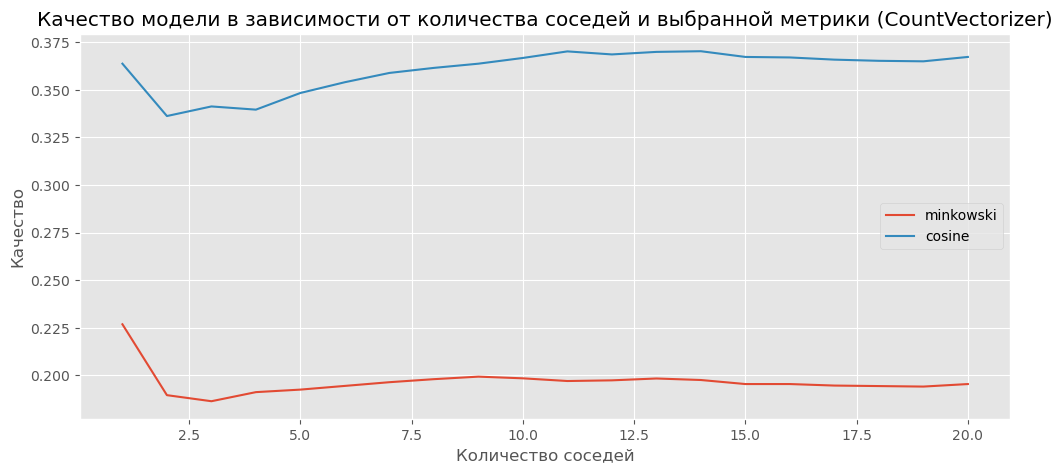

In [296]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 21)]

results_with_minkowski_count = best_nn(X, y, 'brute')
results_with_cosine_count = best_nn(X, y, 'brute', 'cosine')

plt.title('Качество модели в зависимости от количества соседей и выбранной метрики (CountVectorizer)')
plt.xlabel('Количество соседей')
plt.ylabel('Качество')
plt.plot(x, results_with_minkowski_count[2], label='minkowski')
plt.plot(x, results_with_cosine_count[2], label='cosine')

plt.legend()
plt.show()

In [297]:
vectorizer = TfidfVectorizer(min_df=30, max_df=0.5)
vectorizer.fit(data)
X = vectorizer.transform(data).toarray()
y = target

100%|█████████████████████████████████████████████| 20/20 [02:28<00:00,  7.44s/it]


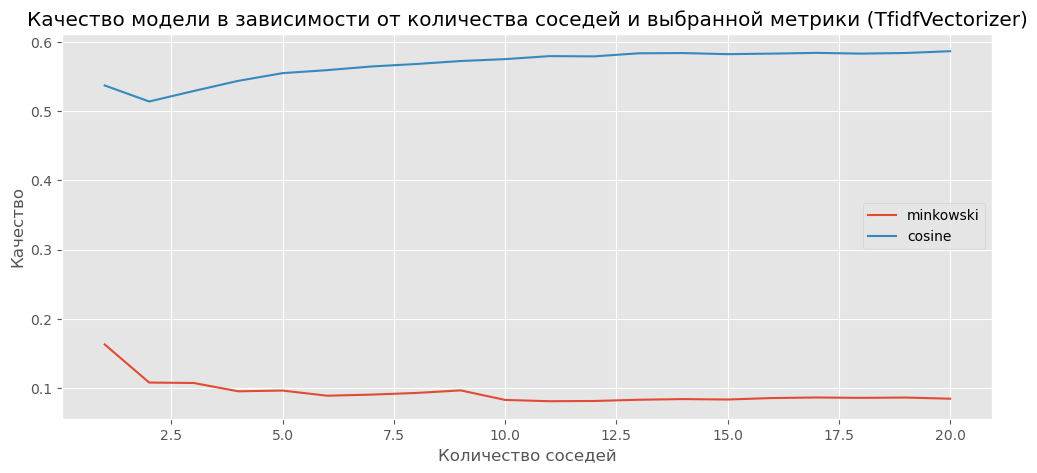

In [298]:
x = [i for i in range(1, 21)]

results_with_minkowski_tfidf = best_nn(X, y, 'brute')
results_with_cosine_tfidf = best_nn(X, y, 'brute', 'cosine')

plt.title('Качество модели в зависимости от количества соседей и выбранной метрики (TfidfVectorizer)')
plt.xlabel('Количество соседей')
plt.ylabel('Качество')
plt.plot(x, results_with_minkowski_tfidf[2], label='minkowski')
plt.plot(x, results_with_cosine_tfidf[2], label='cosine')
plt.legend()

plt.show()

Лучшее качество показала модель, которая использует косинусную метрику и TfidfVectorizer

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [299]:
newsgroups = fetch_20newsgroups(subset='test',remove=('headers','footers', 'quotes'))

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

Каечство отличается от качества на кросс-валидации. Возможно из-за разницы в балансе классов в тестовой и обучающей выборках. Также влияет наличие новых слов в тестовой части, которых не было в трейне.

In [300]:
X_test = newsgroups['data']
y_test = newsgroups['target']

X_test = vectorizer.transform(newsgroups['data']).toarray()

my_clf = KNeighborsClassifier(n_neighbors=i, algorithm='brute', metric='cosine')
my_clf.fit(X, y)
preds = my_clf.predict(X_test)
accuracy_score(y_test, preds)

0.5112851832182688

# Линейные модели (5 баллов)

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

### Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. 

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [419]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    X_batch = np.array(X)
    y_batch = np.array(y)
    if shuffle == False:
        for i in range(0, len(X), batch_size):
            X_batch = X_batch[i : i + batch_size]
            y_batch = y_batch[i : i + batch_size]
            yield (X_batch, y_batch)
    else:
        assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))
    for batch_start in range(0, X.shape[0]//batch_size):
        yield X[perm][batch_size*batch_start : (batch_start+1) * batch_size], y[perm][batch_size*batch_start: (batch_start+1) * batch_size]

In [420]:
my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1)

In [421]:
X_test.shape

(7532, 4505)

In [439]:
#%%pycodestyle

def logit(x, w):
    return np.dot(x, w)

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    sigm_value_x = 1. / (1 + np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            pred = X_batch @ self.weights
            loss = np.sum((pred - y_batch) ** 2) / len(y)
            loss += np.sum(self.weights ** 2) / self.C
            
        if self.model_type == 'log_reg':
            pred = sigmoid(logit(X_batch, self.weights))
            loss = (np.sum(y * np.log(pred) + (1 - y_batch) * np.log(1 - pred))) / len(y)
            loss += np.sum(self.weights ** 2) / self.C
            
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            pred = X_batch @ self.weights
            loss_grad = 2 * (pred - y_batch)[:, np.newaxis] * X_batch
            loss_grad = loss_grad.mean(axis=0)
            
        elif self.model_type == 'log_reg':
            pred = sigmoid(logit(X_batch, self.weights))
            loss_grad = np.dot(X_batch.T, (pred - y_batch)) / len(y)
        
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad

    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        
        self.weights = np.random.rand(len(X[0]) + 1)
        for n in tqdm(range(0, self.max_epoch)):
            new_epoch_generator = self.batch_generator(X, y)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                n, k = X_batch.shape
                X_batch = np.hstack((np.ones((n, 1)), X_batch))
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        n, k = X.shape
        X = np.hstack((np.ones((n, 1)), X))
        if self.model_type == 'lin_reg':
            y_hat = X @ self.weights
        elif self.model_type == 'log_reg':
            y_hat = sigmoid(logit(X, self.weights))
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat >= 0.8

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [497]:
my_linear_reg = MySGDClassifier(batch_generator)
my_log_reg = MySGDClassifier(batch_generator, model_type='log_reg')
# my_clf.fit(X_test, y_test)

In [498]:
def plot_decision_boundary(clf, X, label='lin_reg', c='r'):
    X = np.arange(np.min(X), np.max(X))
    y = (clf.weights[0] + clf.weights[1] * X) / clf.weights[2]

    return plt.plot(X, y, label=label, c=c)

100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 114.46it/s]


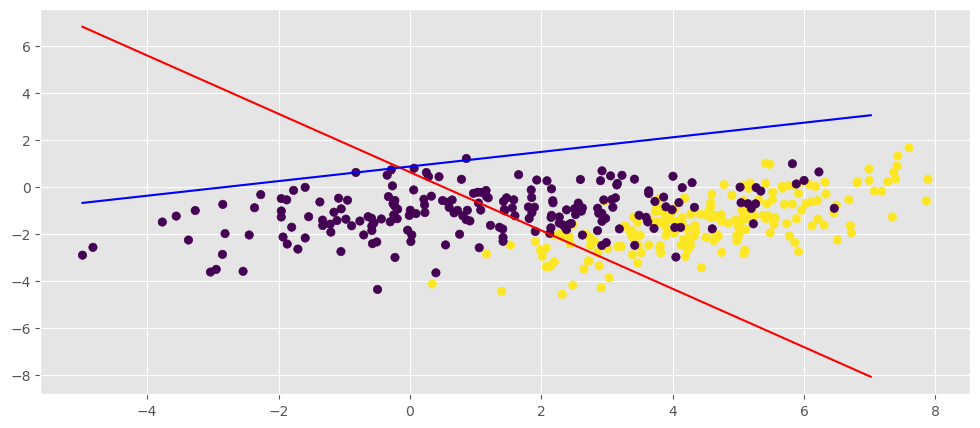

In [499]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_linear_reg.fit(X, y)
my_log_reg.fit(X, y)
# print(my_clf.errors_log)

plot_decision_boundary(my_linear_reg, X)
plot_decision_boundary(my_log_reg, X, label='log_reg', c='b')

plt.scatter(X[:,0], X[:,1], c=y)

In [436]:
from sklearn.metrics import accuracy_score

pred_lin_reg = my_linear_reg.predict(X)
pred_log_reg = my_log_reg.predict(X)

print('lin_reg_acc =', accuracy_score(pred_lin_reg, y))
print('log_reg_acc =', accuracy_score(pred_log_reg, y))

lin_reg_acc = 0.875
log_reg_acc = 0.55


Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [485]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [491]:
my_linear_reg.fit(X_train, y_train)
max_epoch = 10

all_losses = []
all_alpha = [i/1000 for i in range(1, 15, 2)]

for alpha in all_alpha:
    losses = []
    for N in range(1, 40):
        X_train_clip, y_train_clip = X_train, y_train
        lin_reg_clf = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=max_epoch, alpha=alpha)
        lin_reg_clf.fit(X_train_clip, y_train_clip)
        loss = np.sum(np.array(lin_reg_clf.errors_log['loss'])) / (max_epoch * N)
        losses.append(loss)
        tqdm._instances.clear()
    all_losses.append(losses)

print(all_alpha)
print(all_losses)

100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 410.98it/s]


100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 406.64it/s]


100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 409.77it/s]

[0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013]
[[141.61648785868698, 70.80824392934349, 47.20549595289565, 35.404121964671745, 28.323297571737395, 23.602747976447827, 20.23092683695528, 17.702060982335873, 15.735165317631886, 14.161648785868698, 12.874226168971543, 11.801373988223913, 10.893575989129767, 10.11546341847764, 9.44109919057913, 8.851030491167936, 8.330381638746292, 7.867582658815943, 7.453499360983525, 7.080824392934349, 6.743642278985094, 6.437113084485771, 6.157238602551607, 5.900686994111957, 5.664659514347479, 5.446787994564883, 5.245055105877295, 5.05773170923882, 4.88332716754093, 4.720549595289565, 4.568273801893128, 4.425515245583968, 4.291408722990514, 4.165190819373146, 4.046185367391057, 3.9337913294079714, 3.8274726448293777, 3.7267496804917624, 3.631191996376589], [126.55074110638073, 63.27537055319036, 42.18358036879358, 31.63768527659518, 25.310148221276144, 21.09179018439679, 18.078677300911533, 15.81884263829759, 14.061193456264524, 12.655074110638072, 

<function matplotlib.pyplot.show(close=None, block=None)>

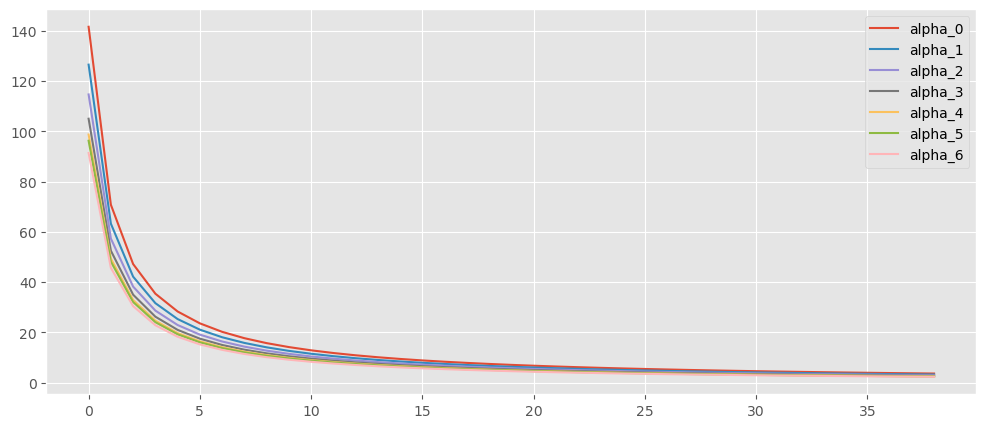

In [492]:
for i in range(len(all_alpha)):
    plt.plot(np.arange(0, len(all_losses[i])), all_losses[i], label=f'alpha_{i}')
plt.legend()
plt.show

In [481]:
all_alpha[3]

0.007

In [503]:
my_linear_reg.fit(X_train, y_train)
max_epoch = 10

all_losses = []
all_alpha = [i/1000 for i in range(1, 15, 2)]

for alpha in all_alpha:
    losses = []
    for N in range(1000, 2000, 50):
        X_train_clip, y_train_clip = X_train[:N], y_train[:N]

        log_reg_clf = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=max_epoch, alpha=alpha)
        log_reg_clf.fit(X, y)
        loss = np.sum(np.array(lin_reg_clf.errors_log['loss'])) / (max_epoch * N)
        losses.append(loss)
        tqdm._instances.clear()
    all_losses.append(losses)

print(all_alpha)
print(all_losses)

100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 114.57it/s]


100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 112.07it/s]

[0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013]
[[0.09138048687536482, 0.08702903511939507, 0.08307316988669529, 0.07946129293509985, 0.07615040572947068, 0.07310438950029186, 0.07029268221181909, 0.06768924953730728, 0.0652717763395463, 0.06302102543128608, 0.060920324583576546, 0.058955152822816013, 0.05711280429710301, 0.05538211325779686, 0.05375322757374401, 0.05221742107163704, 0.05076693715298045, 0.04939485777046747, 0.04809499309229727, 0.04686178814121273], [0.09138048687536482, 0.08702903511939507, 0.08307316988669529, 0.07946129293509985, 0.07615040572947068, 0.07310438950029186, 0.07029268221181909, 0.06768924953730728, 0.0652717763395463, 0.06302102543128608, 0.060920324583576546, 0.058955152822816013, 0.05711280429710301, 0.05538211325779686, 0.05375322757374401, 0.05221742107163704, 0.05076693715298045, 0.04939485777046747, 0.04809499309229727, 0.04686178814121273], [0.09138048687536482, 0.08702903511939507, 0.08307316988669529, 0.07946129293509985, 0.0761504057294706

<function matplotlib.pyplot.show(close=None, block=None)>

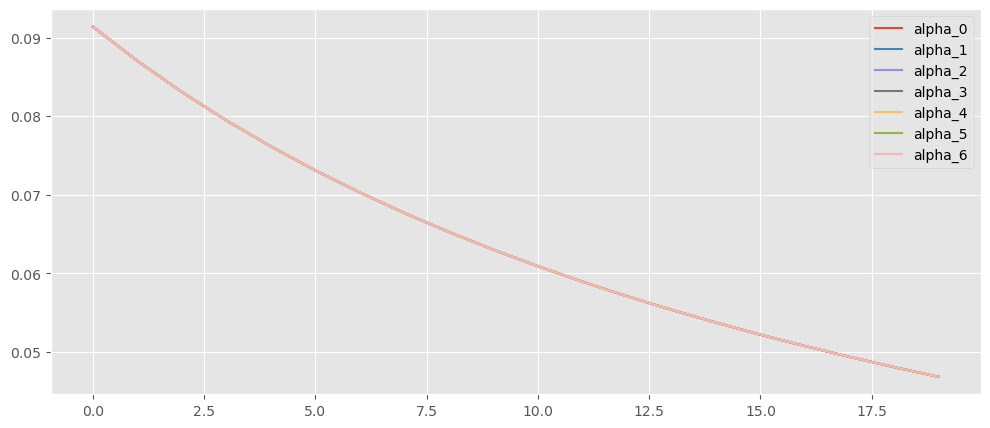

In [504]:
for i in range(len(all_alpha)):
    plt.plot(np.arange(0, len(all_losses[i])), all_losses[i], label=f'alpha_{i}')
plt.legend()
plt.show

In [512]:
all_losses

[[0.09138048687536482,
  0.08702903511939507,
  0.08307316988669529,
  0.07946129293509985,
  0.07615040572947068,
  0.07310438950029186,
  0.07029268221181909,
  0.06768924953730728,
  0.0652717763395463,
  0.06302102543128608,
  0.060920324583576546,
  0.058955152822816013,
  0.05711280429710301,
  0.05538211325779686,
  0.05375322757374401,
  0.05221742107163704,
  0.05076693715298045,
  0.04939485777046747,
  0.04809499309229727,
  0.04686178814121273],
 [0.09138048687536482,
  0.08702903511939507,
  0.08307316988669529,
  0.07946129293509985,
  0.07615040572947068,
  0.07310438950029186,
  0.07029268221181909,
  0.06768924953730728,
  0.0652717763395463,
  0.06302102543128608,
  0.060920324583576546,
  0.058955152822816013,
  0.05711280429710301,
  0.05538211325779686,
  0.05375322757374401,
  0.05221742107163704,
  0.05076693715298045,
  0.04939485777046747,
  0.04809499309229727,
  0.04686178814121273],
 [0.09138048687536482,
  0.08702903511939507,
  0.08307316988669529,
  0.079

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

В нашем случае наилучшую сходимость показал параметр alpha = 0.007 для линейной регрессии. Для лучшей сходимости необходимо выбирать небольшое значение, которое позволит быстро сходиться в точку минимума, но при этом не позволит "перейти" через неё. В нашем случае при каждом коэффициенте alpha, loss уменьшался.

Для логистической регресси были показаны одинаковые результаты для каждого alpha.

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [508]:
all_C = np.logspace(3, -3, 10)
weights_avgs_lin_reg = []
weights_avgs_log_reg = []
for C in all_C:
    log_reg_clf = MySGDClassifier(batch_generator, model_type='log_reg', C=C)
    lin_reg_clf = MySGDClassifier(batch_generator, model_type='lin_reg', C=C)
    log_reg_clf.fit(X, y)
    lin_reg_clf.fit(X, y)
    weights_avgs_log_reg.append(np.mean(log_reg_clf.weights))
    weights_avgs_lin_reg.append(np.mean(lin_reg_clf.weights))

100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 136.82it/s]


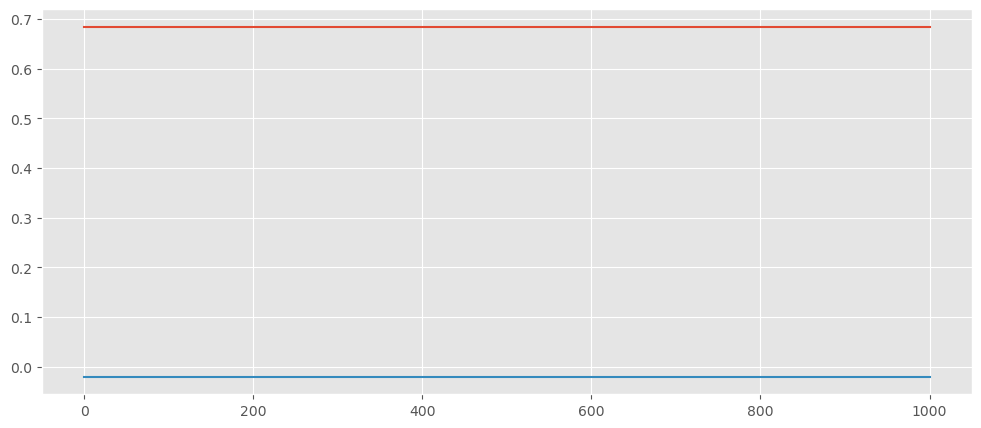

In [509]:
plt.plot(all_C, weights_avgs_log_reg)
plt.plot(all_C, weights_avgs_lin_reg)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? Почему-то не произошло изменения весов.